<a href="https://colab.research.google.com/github/dpqhd01/medical_cap/blob/main/Colab_SingleNetworkLSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

✅ Device: cpu
Trial shape: (100, 513)
Orphanet shape: (22501, 513)
✅ 임베딩 차원: 512
✅ 입력 shape: (200, 2, 512) | 라벨 수: 200


Epoch 1: 100%|██████████| 5/5 [00:00<00:00, 22.32it/s]


Epoch [1/10] | Loss: 0.6950 | F1: 0.4082


Epoch 2: 100%|██████████| 5/5 [00:00<00:00, 106.89it/s]


Epoch [2/10] | Loss: 0.6925 | F1: 0.1176


Epoch 3: 100%|██████████| 5/5 [00:00<00:00, 127.30it/s]


Epoch [3/10] | Loss: 0.6921 | F1: 0.0000


Epoch 4: 100%|██████████| 5/5 [00:00<00:00, 118.67it/s]


Epoch [4/10] | Loss: 0.6915 | F1: 0.0667


Epoch 5: 100%|██████████| 5/5 [00:00<00:00, 115.98it/s]


Epoch [5/10] | Loss: 0.6904 | F1: 0.0000


Epoch 6: 100%|██████████| 5/5 [00:00<00:00, 117.71it/s]


Epoch [6/10] | Loss: 0.6895 | F1: 0.0000


Epoch 7: 100%|██████████| 5/5 [00:00<00:00, 117.65it/s]


Epoch [7/10] | Loss: 0.6887 | F1: 0.0645


Epoch 8: 100%|██████████| 5/5 [00:00<00:00, 111.97it/s]


Epoch [8/10] | Loss: 0.6872 | F1: 0.0645


Epoch 9: 100%|██████████| 5/5 [00:00<00:00, 123.47it/s]


Epoch [9/10] | Loss: 0.6861 | F1: 0.0645


Epoch 10: 100%|██████████| 5/5 [00:00<00:00, 121.35it/s]


Epoch [10/10] | Loss: 0.6849 | F1: 0.0000

=== 최종 Classification Report (Single LSTM Encoder on Embeddings) ===
              precision    recall  f1-score   support

         0.0     0.3226    0.5263    0.4000        19
         1.0     0.0000    0.0000    0.0000        21

    accuracy                         0.2500        40
   macro avg     0.1613    0.2632    0.2000        40
weighted avg     0.1532    0.2500    0.1900        40



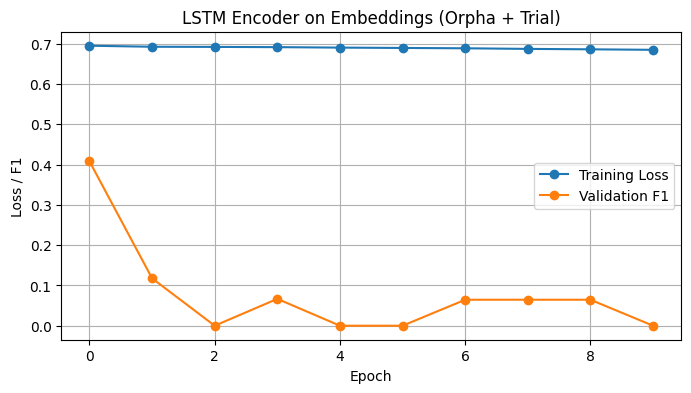

In [1]:
# ======================================
# 🔧 라이브러리
# ======================================
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import classification_report, f1_score
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("✅ Device:", device)

# ======================================
# 1️⃣ CSV 불러오기
# ======================================
trial = pd.read_csv("/content/trial_embeddings.csv")
orpha = pd.read_csv("/content/orpanet_embeddings.csv")

print("Trial shape:", trial.shape)
print("Orphanet shape:", orpha.shape)

# 벡터 부분만 추출 (첫 컬럼 제외)
trial_vecs = trial.iloc[:, 1:].values.astype(np.float32)
orpha_vecs = orpha.iloc[:, 1:].values.astype(np.float32)

# 차원 확인
assert trial_vecs.shape[1] == orpha_vecs.shape[1], "⚠️ 두 임베딩의 차원이 다릅니다!"

embedding_dim = trial_vecs.shape[1]
print(f"✅ 임베딩 차원: {embedding_dim}")

# ======================================
# 2️⃣ 입력 시퀀스 생성
# ======================================
# 예시: Orphanet과 Trial을 각각 쌍으로 연결 (순서 맞추기 or 랜덤 샘플링)
n = min(len(orpha_vecs), len(trial_vecs))
pairs = []
labels = []

for i in range(n):
    pairs.append(np.stack([orpha_vecs[i], trial_vecs[i]], axis=0))  # 매칭쌍 → label=1
    labels.append(1)

# 불일치 샘플도 일부 섞기
for i in range(n):
    j = np.random.randint(0, n)
    pairs.append(np.stack([orpha_vecs[i], trial_vecs[j]], axis=0))  # 랜덤쌍 → label=0
    labels.append(0)

pairs = np.array(pairs)   # (2n, 2, 512)
labels = np.array(labels)

print("✅ 입력 shape:", pairs.shape, "| 라벨 수:", len(labels))

# ======================================
# 3️⃣ Dataset 정의
# ======================================
class EmbeddingDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)
    def __len__(self): return len(self.X)
    def __getitem__(self, idx): return self.X[idx], self.y[idx]

X_train, X_test, y_train, y_test = train_test_split(pairs, labels, test_size=0.2, random_state=42)
train_ds = EmbeddingDataset(X_train, y_train)
test_ds = EmbeddingDataset(X_test, y_test)
train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=32)

# ======================================
# 4️⃣ LSTM 인코더 정의
# ======================================
class LSTMVectorEncoder(nn.Module):
    def __init__(self, input_dim, hidden_dim=128):
        super(LSTMVectorEncoder, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True)
        self.dropout = nn.Dropout(0.3)
        self.fc = nn.Linear(hidden_dim, 1)
    def forward(self, x):
        _, (h, _) = self.lstm(x)
        h = self.dropout(h[-1])
        out = self.fc(h)
        return torch.sigmoid(out).squeeze()

model = LSTMVectorEncoder(input_dim=embedding_dim).to(device)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# ======================================
# 5️⃣ 학습 루프
# ======================================
train_loss_list, val_f1_list = [], []

for epoch in range(10):
    model.train()
    total_loss = 0
    for Xb, yb in tqdm(train_loader, desc=f"Epoch {epoch+1}"):
        Xb, yb = Xb.to(device), yb.to(device)
        optimizer.zero_grad()
        outputs = model(Xb)
        loss = criterion(outputs, yb)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    avg_loss = total_loss / len(train_loader)
    train_loss_list.append(avg_loss)

    # 검증
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for Xb, yb in test_loader:
            Xb = Xb.to(device)
            probs = model(Xb).cpu().numpy()
            preds = (probs > 0.5).astype(int)
            all_preds.extend(preds)
            all_labels.extend(yb.numpy())
    f1 = f1_score(all_labels, all_preds)
    val_f1_list.append(f1)
    print(f"Epoch [{epoch+1}/10] | Loss: {avg_loss:.4f} | F1: {f1:.4f}")

# ======================================
# 6️⃣ 최종 평가
# ======================================
print("\n=== 최종 Classification Report (Single LSTM Encoder on Embeddings) ===")
print(classification_report(all_labels, all_preds, digits=4))

plt.figure(figsize=(8,4))
plt.plot(train_loss_list, label="Training Loss", marker='o')
plt.plot(val_f1_list, label="Validation F1", marker='o')
plt.title("LSTM Encoder on Embeddings (Orpha + Trial)")
plt.xlabel("Epoch")
plt.ylabel("Loss / F1")
plt.legend()
plt.grid()
plt.show()
